In [2]:
import iris
from iris.experimental.equalise_cubes import equalise_attributes
import numpy as np
import glob
import matplotlib.pyplot as plt
from cf_units import Unit
import warnings

In [3]:
def get_concatenated_cube(path):
    files = glob.glob(path, recursive=True)
    if files:
        files.sort()
        cube_list = iris.load(files)
        equalise_attributes(cube_list)
        out_cube = cube_list.concatenate_cube()
        return out_cube
    else:
        warnings.warn(f'No files in {path}')
        return

In [4]:
def cube_multiply(big_cube, small_cube):
    dim_diff = big_cube.ndim - small_cube.ndim
    assert big_cube.shape[dim_diff:] == small_cube.shape
    temp_cube = small_cube.copy() #as to not make changes to small_cube
    for coord in big_cube.coords():
        if coord not in temp_cube.coords():
            temp_cube.add_aux_coord(coord[0])
    out_cube = big_cube * temp_cube
    return out_cube

In [5]:
model_path = {'ACCESS-CM2': '/g/data/fs38/publications/CMIP6/FAFMIP/CSIRO-ARCCSS/ACCESS-CM2/',
              'CAS-ESM2-0': '/g/data/oi10/replicas/CMIP6/FAFMIP/CAS/CAS-ESM2-0/',
              'FGOALS-g3': '/g/data/oi10/replicas/CMIP6/FAFMIP/CAS/FGOALS-g3/',
              'CANESM5': '/g/data/oi10/replicas/CMIP6/FAFMIP/CCCma/CanESM5/',
              'MIROC6': '/g/data/oi10/replicas/CMIP6/FAFMIP/MIROC/MIROC6/',
              'MPI-ESM1-2-HR': '/g/data/oi10/replicas/CMIP6/FAFMIP/MPI-M/MPI-ESM1-2-HR/',
              'MRI-ESM2-0': '/g/data/oi10/replicas/CMIP6/FAFMIP/MRI/MRI-ESM2-0/',
              'CESM2': '/g/data/oi10/replicas/CMIP6/FAFMIP/NCAR/CESM2/',
              'GFDL-ESM2M': '/g/data/oi10/replicas/CMIP6/FAFMIP/NOAA-GFDL/GFDL-ESM2M/'
             }

In [6]:
experiment_path = {'faf-heat': 'faf-heat/r1i1p1f1/',
                   'faf-passiveheat': 'faf-passiveheat/r1i1p1f1/',
                   'faf-water': 'faf-water/r1i1p1f1/',
                   'faf-stress': 'faf-stress/r1i1p1f1/',
                   'faf-all': 'faf-all/r1i1p1f1/'
                  }

In [7]:
variable_path = {'areacello': 'Ofx/areacello/gn/v*/**/*.nc',
                 'volcello': 'Ofx/volcello/gn/v*/**/*.nc',
                 'thetao': 'Omon/thetao/gn/v*/**/*.nc',
                 'bigthetao': 'Omon/bigthetao/gn/v*/**/*.nc',
                 'hfds': 'Omon/hfds/gn/v*/**/*.nc',
                 'ocontemptend': 'Oyr/ocontemptend/gn/v*/**/*.nc',
                 'opottemptend': 'Oyr/opottemptend/gn/v*/**/*.nc'
                }

In [8]:
model = 'ACCESS-CM2'
experiment = 'faf-heat'

In [9]:
cube_list = {}
for var, path in variable_path.items():
    #print(model_path[model]+experiment_path[experiment]+path)
    cube_list[var] = get_concatenated_cube(model_path[model]+experiment_path[experiment]+path)

/g/data/e14/sw4281/miniconda3/envs/ra/lib/python3.9/site-packages/iris/fileformats/cf.py:803: UserWarning: Missing CF-netCDF measure variable 'areacello', referenced by netCDF variable 'volcello'
  warnings.warn(message % (variable_name, nc_var_name))
/g/data/e14/sw4281/miniconda3/envs/ra/lib/python3.9/site-packages/iris/fileformats/cf.py:803: UserWarning: Missing CF-netCDF measure variable 'areacello', referenced by netCDF variable 'thetao'
  warnings.warn(message % (variable_name, nc_var_name))
/g/data/e14/sw4281/miniconda3/envs/ra/lib/python3.9/site-packages/iris/fileformats/cf.py:803: UserWarning: Missing CF-netCDF measure variable 'volcello', referenced by netCDF variable 'thetao'
  warnings.warn(message % (variable_name, nc_var_name))
/g/data/e14/sw4281/miniconda3/envs/ra/lib/python3.9/site-packages/iris/fileformats/cf.py:803: UserWarning: Missing CF-netCDF measure variable 'areacello', referenced by netCDF variable 'thetao'
  warnings.warn(message % (variable_name, nc_var_name))

In [10]:
watt_cube = cube_multiply(cube_list['ocontemptend'],cube_list['areacello'])

In [231]:
np.histogram(cube_list['bigthetao'].data.compressed())

KeyboardInterrupt: 

In [ ]:
dist, edges = np.histogram(cube_list['bigthetao'].data.compressed(),bins=100,weights=watt_cube.data.compressed())

In [ ]:
plt.plot(edges[1:],np.cumsum(dist[::-1]/840.)[::-1])

In [181]:
watt_cube=cube_multiply(cube_list['hfds'],cube_list['areacello'])

In [182]:
surf_cube=cube_list['thetao'].extract(iris.Constraint(depth=0))

In [183]:
dist,edges = np.histogram(surf_cube.data.compressed(),bins=100,weights=watt_cube.data.compressed())

In [184]:
#hfds_plot={}
hfds_plot[experiment] = [dist,edges]

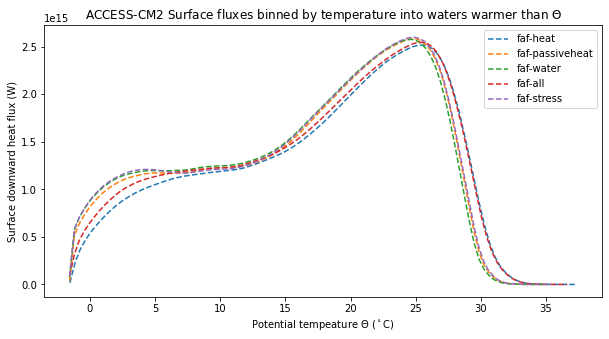

In [213]:
fig,ax = plt.subplots(figsize=(10,5))
for exp in hfds_plot:
    ax.plot(hfds_plot[exp][1][1:],np.cumsum(hfds_plot[exp][0][::-1]/840.)[::-1],'--',label=exp)
ax.legend()
ax.set_title(r'ACCESS-CM2 Surface fluxes binned by temperature into waters warmer than $\Theta$')
ax.set_ylabel('Surface downward heat flux (W)')
ax.set_xlabel(r'Potential tempeature $\Theta$ ($^\circ$C)')
fig.savefig('../results/ACCESS-CM2_surface_fluxes_temp',dpi=1000)

In [201]:
cube_list['hfds']

<iris 'Cube' of surface_downward_heat_flux_in_sea_water / (W m-2) (time: 840; cell index along second dimension: 300; cell index along first dimension: 360)>